**Import Necessary Libraries**

In [1]:
import requests
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

**Setup Environment to Generate Synthetic Stock Price Data**

In [2]:
# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [3]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


**Implement Multi-Head Self-Attention**

In [4]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output

**Implement Transformer Block**

In [5]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

**Implement Encoder Layer**

In [6]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

**Implement Transformer Encoder**

In [7]:
class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 
    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 
    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

(1, 100, 128)


**Build and Compile Transformer Model**

In [8]:
# Define the necessary parameters 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
dense_48 (Dense)             (None, 100, 128)          256       
_________________________________________________________________
transformer_encoder_1 (Trans (None, 100, 128)          793088    
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 12801     
Total params: 806,145
Trainable params: 806,145
Non-trainable params: 0
_________________________________________________________________


**Train Transformer Model**

In [9]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

Epoch 1/20
60/60 [==============================] - 5s 27ms/step - loss: 4.1179
Epoch 2/20
60/60 [==============================] - 2s 28ms/step - loss: 0.2025
Epoch 3/20
60/60 [==============================] - 2s 27ms/step - loss: 0.1877
Epoch 4/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1671
Epoch 5/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1930
Epoch 6/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1853
Epoch 7/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1725
Epoch 8/20
60/60 [==============================] - 1s 24ms/step - loss: 0.1341
Epoch 9/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1459
Epoch 10/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1171
Epoch 11/20
60/60 [==============================] - 1s 25ms/step - loss: 0.1240
Epoch 12/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0911
Epoch 13/20
60/60 [==================

**Evaluate and Make Predictions**

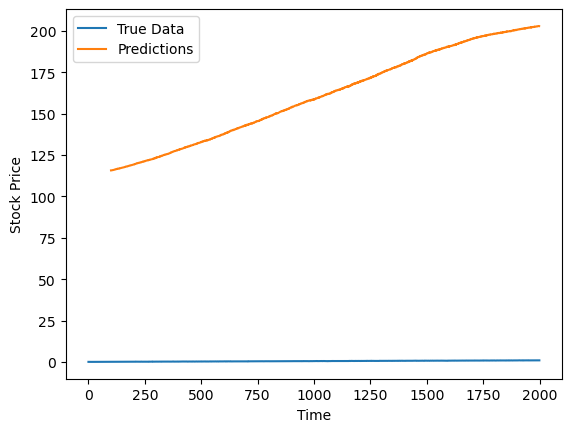

In [10]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 
 
# Plot the predictions 
plt.plot(data, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.show() 

**Add Dropout to Transformer Model**

In [11]:
# Add a dropout layer after the Flatten layer 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
dropout = Dropout(0.5)(flatten) 
outputs = tf.keras.layers.Dense(1)(dropout) 

# Build the model 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Train the model 
model.fit(X, Y, epochs=20, batch_size=32) 

# Evaluate the model 
loss = model.evaluate(X, Y) 
print(f'Test loss: {loss}') 

Epoch 1/20
60/60 [==============================] - 5s 28ms/step - loss: 2.4888
Epoch 2/20
60/60 [==============================] - 2s 25ms/step - loss: 0.7695
Epoch 3/20
60/60 [==============================] - 1s 25ms/step - loss: 0.2734
Epoch 4/20
60/60 [==============================] - 2s 25ms/step - loss: 0.1032
Epoch 5/20
60/60 [==============================] - 2s 26ms/step - loss: 0.0467
Epoch 6/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0312
Epoch 7/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0254
Epoch 8/20
60/60 [==============================] - 2s 26ms/step - loss: 0.0219
Epoch 9/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0188
Epoch 10/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0220
Epoch 11/20
60/60 [==============================] - 2s 26ms/step - loss: 0.0205
Epoch 12/20
60/60 [==============================] - 2s 25ms/step - loss: 0.0150
Epoch 13/20
60/60 [==================

**Experiment with Different Batch Sizes**

In [12]:
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0187
Epoch 2/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0237
Epoch 3/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0251
Epoch 4/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0313
Epoch 5/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0256
Epoch 6/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0296
Epoch 7/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0186
Epoch 8/20
119/119 [==============================] - 3s 21ms/step - loss: 0.0196
Epoch 9/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0220
Epoch 10/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0237
Epoch 11/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0289
Epoch 12/20
119/119 [==============================] - 2s 21ms/step - loss: 0.0144
Epoch 13/20
1

**Use a Different Activation Function**

In [13]:
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 [==============================] - 5s 28ms/step - loss: 0.2879
Epoch 2/20
60/60 [==============================] - 2s 26ms/step - loss: 0.2959
Epoch 3/20
60/60 [==============================] - 2s 27ms/step - loss: 0.2966
Epoch 4/20
60/60 [==============================] - 2s 27ms/step - loss: 0.2993
Epoch 5/20
60/60 [==============================] - 2s 26ms/step - loss: 0.2967
Epoch 6/20
60/60 [==============================] - 2s 26ms/step - loss: 0.2967
Epoch 7/20
60/60 [==============================] - 2s 27ms/step - loss: 0.2967
Epoch 8/20
60/60 [==============================] - 1s 25ms/step - loss: 0.2966
Epoch 9/20
60/60 [==============================] - 2s 25ms/step - loss: 0.2938
Epoch 10/20
60/60 [==============================] - 1s 25ms/step - loss: 0.2967
Epoch 11/20
60/60 [==============================] - 1s 25ms/step - loss: 0.2967
Epoch 12/20
60/60 [==============================] - 2s 25ms/step - loss: 0.2967
Epoch 13/20
60/60 [==================